In [1]:
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from utils import dref_dataframe, dump_dref
import matplotlib
from scipy import integrate
from statistics import stdev

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")


@dataclass
class BTimes:
    build: list[float]
    delay: list[float]
    clean: float | None
    drop: float
    cpu: dict[str, float]


def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    return pd.DataFrame(out)


def load_mode(max_mem: int, mode: str, path: Path, i=0) -> tuple[pd.DataFrame, BTimes]:
    data = pd.read_csv(path / f"out_{i}.csv")
    data["mode"] = mode
    if "time" not in data.columns:
        data["time"] = data.index
    if "total" not in data.columns:
        data["total"] = max_mem
    data["small"] = data["total"] - data["small"] * 2**12
    data["huge"] = data["total"] - data["huge"] * 2**(12+9)

    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["rss", "small", "huge", "cached"])

    raw: dict = json.load((path / f"times_{i}.json").open())
    times = BTimes(
        x if isinstance(x := raw["build"], list) else [x],
        y if isinstance(y := raw["delay"], list) else [y],
        raw.get("clean"),
        raw["drop"] if "drop" in raw else raw["shrink"],
        raw["cpu"]
    )
    return data, times


def load_data(max_mem: int, modes: dict[str, Path]) -> tuple[pd.DataFrame, list[BTimes]]:
    datas: list[pd.DataFrame] = []
    times: list[BTimes] = []
    for mode, path in modes.items():
        data, time = load_mode(max_mem, mode, path)
        datas.append(data)
        times.append(time)
    data = pd.concat(datas, ignore_index=True)
    return data, times


def y_at(data: pd.DataFrame, x: float):
    return data[data["measurement"] == "rss"][(data["time"] - x).abs() < 2]["bytes"].max()


def calc_gib_min(data: pd.DataFrame, start: float, end: float) -> float:
    build_d = data[(start <= data["time"])
        & (data["time"] <= end)
        & (data["measurement"] == "rss")]
    return integrate.trapezoid(build_d["bytes"], x=build_d["time"]) / 1024**3 / 60


def relplot(max_mem: int, data: pd.DataFrame, times: list[BTimes], col_wrap=10) -> tuple[sns.FacetGrid, dict[str, float]]:
    col_wrap = min(col_wrap, len(data["mode"].unique()))
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", col_wrap=col_wrap,
                    hue="measurement", height=5.5, legend=False)
    p.set_titles("{col_name}")
    p.set(ylabel="Memory consumption [GiB]")
    p.set(xlabel="Time [seconds]")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])

    modes = data["mode"].unique()
    extra_keys = {}

    for ax in p.axes:
        ax.get_lines()[0].set(zorder=10, linestyle="dotted")

    h = list(p.axes[0].get_lines())
    l = list(data["measurement"].unique())
    p.add_legend(dict(zip(l, h)), loc="upper center", bbox_to_anchor=(0.31, 0.04), ncol=7, frameon=True)

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]

        tstart = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time.build, time.delay):
            axis.axvspan(
                xmin=tstart, xmax=tbuild, ymax=0.91, edgecolor=sns.crayons["Gray"],
                facecolor="white", zorder=-1, hatch="//")

            b_mid = tstart + (tbuild - tstart)/2
            axis.text(b_mid, max_mem * 1.02, "runtime", horizontalalignment="center",
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])

            gib_m = calc_gib_min(celld, tstart, tbuild)
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tstart:.2f} s")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tstart

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tstart = tdelay
            j += 1

        tdelay = time.delay[-1]
        if time.clean is not None:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay) + max_mem/32),
                (tdelay, max_mem * 0.925),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                arrowprops={"facecolor": sns.crayons["Violet (Purple)"]})
            tdelay = time.clean
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay) + max_mem/32),
            (tdelay, max_mem * 0.85),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
            arrowprops={"facecolor": "black"})
        gib = y_at(celld, time.drop) / 1024**3
        prefix += f"drop {gib:.2f} GiB, "
        extra_keys[f"{modes[i]}/drop/gib"] = gib

        gib_m = calc_gib_min(celld, 0, time.drop)
        prefix += f"{gib_m:.2f} GiB*m"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m

        print(f"{modes[i]}: {prefix}")

    return p, extra_keys


def visualize(max_mem: int, modes: dict[str, Path], save_as: str | None = None, col_wrap=10) -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(max_mem, data, times, col_wrap)
    if save_as:
        p.savefig(Path("compiling") / f"{save_as}.pdf")
        p.savefig(Path("compiling") / f"{save_as}.svg")
        dref_dataframe(save_as, Path("compiling"), ["mode", "measurement", "time"], data)
        with (Path("compiling") / f"{save_as}_extra.dref").open("w+") as f:
            dump_dref(f, save_as, extra_keys)
    return p


## Clang

Buddy: 483.57 GiB*m, 2481.61 s
Buddy: delay 16.04 GiB, clean 16.04 GiB, drop 16.04 GiB, 645.04 GiB*m
LLFree: 500.30 GiB*m, 2437.32 s
LLFree: delay 16.07 GiB, clean 16.07 GiB, drop 16.07 GiB, 661.33 GiB*m


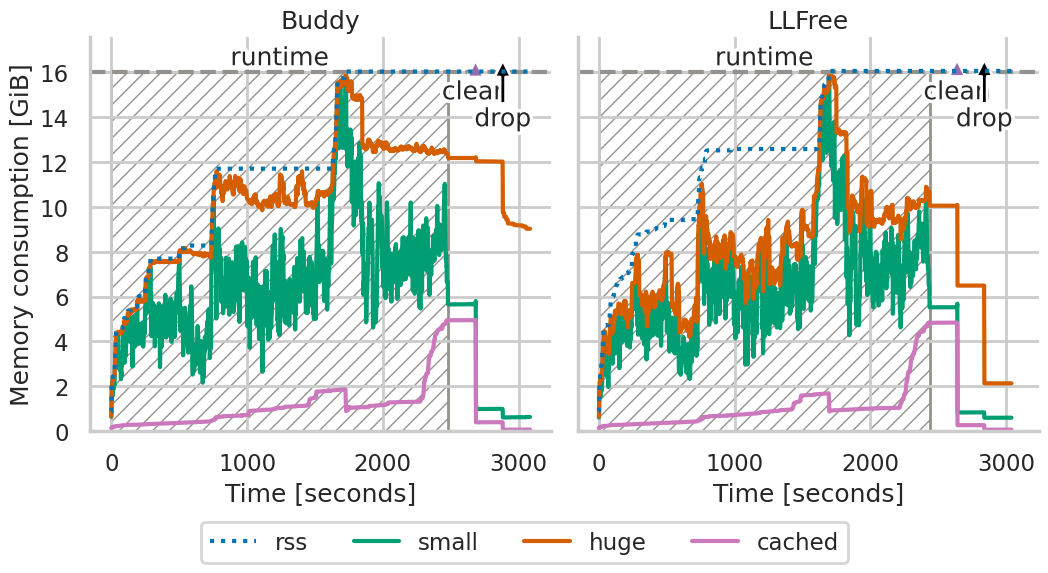

In [2]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy": Path("compiling/latest-clang-base-manual"),
    "LLFree": Path("compiling/latest-clang-llfree-manual"),
}, "clang-baseline")

virtio-balloon: 430.61 GiB*m, 2477.07 s
virtio-balloon: delay 12.22 GiB, clean 11.55 GiB, drop 7.99 GiB, 538.36 GiB*m
HyperAlloc: 357.68 GiB*m, 2447.11 s
HyperAlloc: delay 10.62 GiB, clean 6.86 GiB, drop 1.90 GiB, 422.96 GiB*m


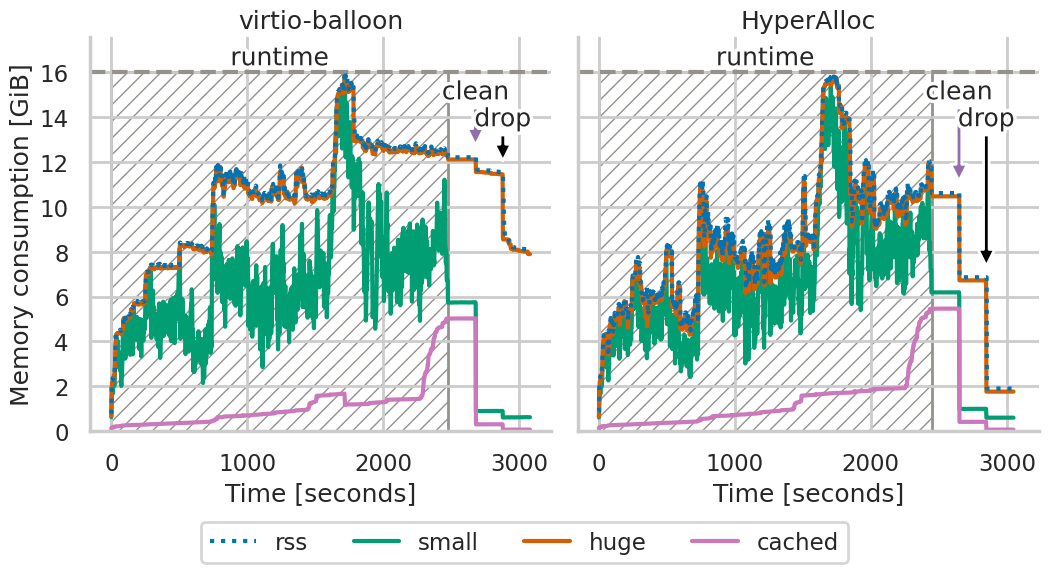

In [3]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "clang-auto")

HyperAlloc+VFIO: 358.56 GiB*m, 2446.14 s
HyperAlloc+VFIO: delay 10.68 GiB, clean 6.92 GiB, drop 2.05 GiB, 425.15 GiB*m
virtio-mem+VFIO: 324.99 GiB*m, 1942.90 s
virtio-mem+VFIO: delay 12.11 GiB, clean 2.61 GiB, drop 2.11 GiB, 384.88 GiB*m


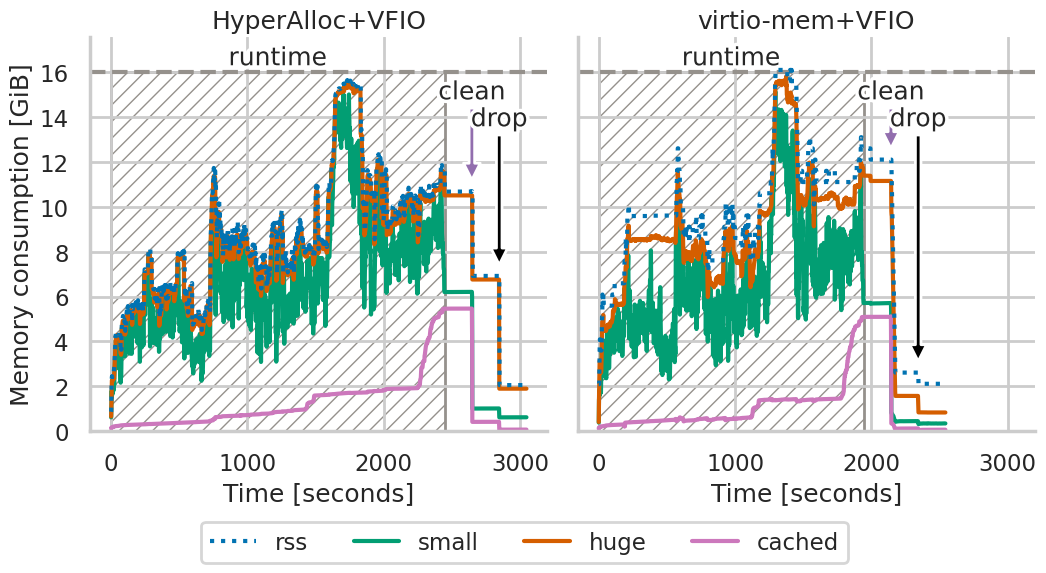

In [7]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "HyperAlloc+VFIO": Path("compiling/latest-clang-llfree-auto-vfio"),
    "virtio-mem+VFIO": Path("compiling/240823-125026-clang-virtio-mem-vfio"),
})

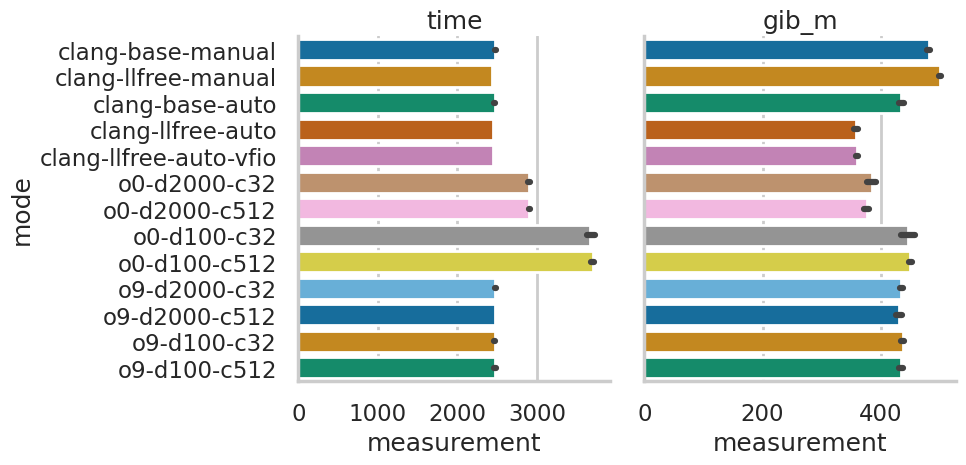

In [10]:
paths = [
    Path("compiling/latest-clang-base-manual"),
    Path("compiling/latest-clang-llfree-manual"),
    Path("compiling/latest-clang-base-auto"),
    Path("compiling/latest-clang-llfree-auto"),
    Path("compiling/latest-clang-llfree-auto-vfio"),
    # Path("compiling/240905-030955-clang-virtio-mem-vfio"),
    Path("compiling/latest-clang-base-auto-o0-d2000-c32"),
    Path("compiling/latest-clang-base-auto-o0-d2000-c512"),
    Path("compiling/latest-clang-base-auto-o0-d100-c32"),
    Path("compiling/latest-clang-base-auto-o0-d100-c512"),
    Path("compiling/latest-clang-base-auto-o9-d2000-c32"),
    Path("compiling/latest-clang-base-auto-o9-d2000-c512"),
    Path("compiling/latest-clang-base-auto-o9-d100-c32"),
    Path("compiling/latest-clang-base-auto-o9-d100-c512"),
]

raw = { "mode": [], "time": [], "gib_m": [] }

max_mem = 16*1024**3
for path in paths:
    build_sum = []
    gibm_sum = []
    for i in range(3):
        name = path.stem

        if name.startswith("latest"):
            name = name[7:]
        else:
            name = name[14:]

        if name.startswith("clang-base-auto-"):
            name = name[16:]

        data, times = load_mode(max_mem, name, path, i)
        raw["mode"].append(name)
        raw["time"].append(times.build[0])
        raw["gib_m"].append(calc_gib_min(data, 0, times.build[0]))

data = pd.DataFrame(data=raw)
data = data.melt(id_vars=["mode"], value_vars=["time", "gib_m"], value_name="measurement")
data.loc[data["mode"] == "o", "mode"] = "HyperAlloc"

p = sns.FacetGrid(data, col="variable", height=5, sharex=False)
p = p.map_dataframe(sns.barplot, y="mode", x="measurement", orient="y", hue="mode", palette="colorblind")
p.set_titles(template="{col_name}")

In [13]:
fpr = data[(data["mode"] == "o9-d2000-c32") & (data["variable"] == "gib_m")]["measurement"].mean()
hyper = data[(data["mode"] == "clang-llfree-auto") & (data["variable"] == "gib_m")]["measurement"].mean()
print(fpr, hyper, 1 - hyper / fpr)

fpr = data[(data["mode"] == "o9-d2000-c32") & (data["variable"] == "time")]["measurement"].mean()
hyper = data[(data["mode"] == "clang-llfree-auto") & (data["variable"] == "time")]["measurement"].mean()
print(fpr, hyper, 1 - hyper / fpr)


435.13998856841187 358.05521436468763 0.17714936854534824
2476.567634741465 2447.146630525589 0.01187974994228147


## SPEC17 Blender

virtio-balloon: 41.74 GiB*m, 328 s
virtio-balloon: 42.56 GiB*m, 328 s
virtio-balloon: 43.03 GiB*m, 328 s
virtio-balloon: delay 3.16 GiB, delay 5.00 GiB, delay 5.70 GiB, drop 4.27 GiB, 202.28 GiB*m
HyperAlloc: 41.75 GiB*m, 328 s
HyperAlloc: 42.06 GiB*m, 326 s
HyperAlloc: 42.51 GiB*m, 329 s
HyperAlloc: delay 1.74 GiB, delay 2.13 GiB, delay 2.50 GiB, drop 1.16 GiB, 158.69 GiB*m


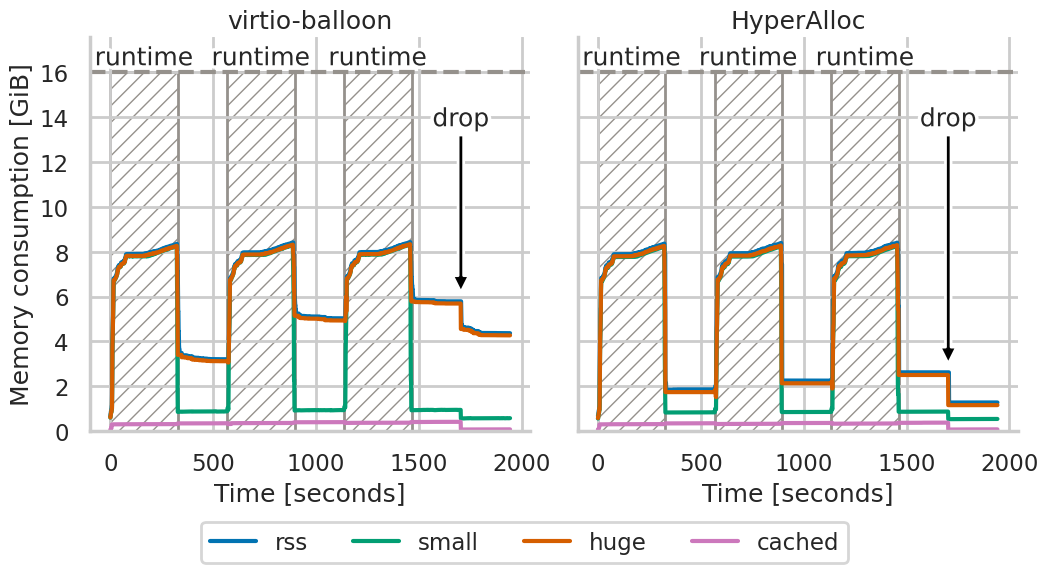

In [17]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-blender-base-auto"),
    "HyperAlloc": Path("compiling/latest-blender-llfree-auto"),
}, "blender-auto")

# Testing

o0-d2000-c32: 0.38 GiB*m, 5.86 s
o0-d2000-c32: delay 6.80 GiB, drop 0.67 GiB, 1.87 GiB*m
o0-d2000-c512: 0.38 GiB*m, 5.81 s
o0-d2000-c512: delay 0.57 GiB, drop 0.53 GiB, 0.73 GiB*m
o0-d100-c32: 0.48 GiB*m, 5.96 s
o0-d100-c32: delay 0.56 GiB, drop 0.52 GiB, 0.65 GiB*m
o0-d100-c512: 0.34 GiB*m, 5.98 s
o0-d100-c512: delay 0.56 GiB, drop 0.53 GiB, 0.60 GiB*m
o9-d2000-c32: 0.66 GiB*m, 5.96 s
o9-d2000-c32: delay 7.26 GiB, drop 2.57 GiB, 2.31 GiB*m
o9-d2000-c512: 0.56 GiB*m, 5.82 s
o9-d2000-c512: delay 2.89 GiB, drop 2.83 GiB, 1.48 GiB*m
o9-d100-c32: 0.38 GiB*m, 5.81 s
o9-d100-c32: delay 2.97 GiB, drop 2.90 GiB, 1.47 GiB*m
o9-d100-c512: 0.39 GiB*m, 5.79 s
o9-d100-c512: delay 2.75 GiB, drop 2.53 GiB, 1.38 GiB*m


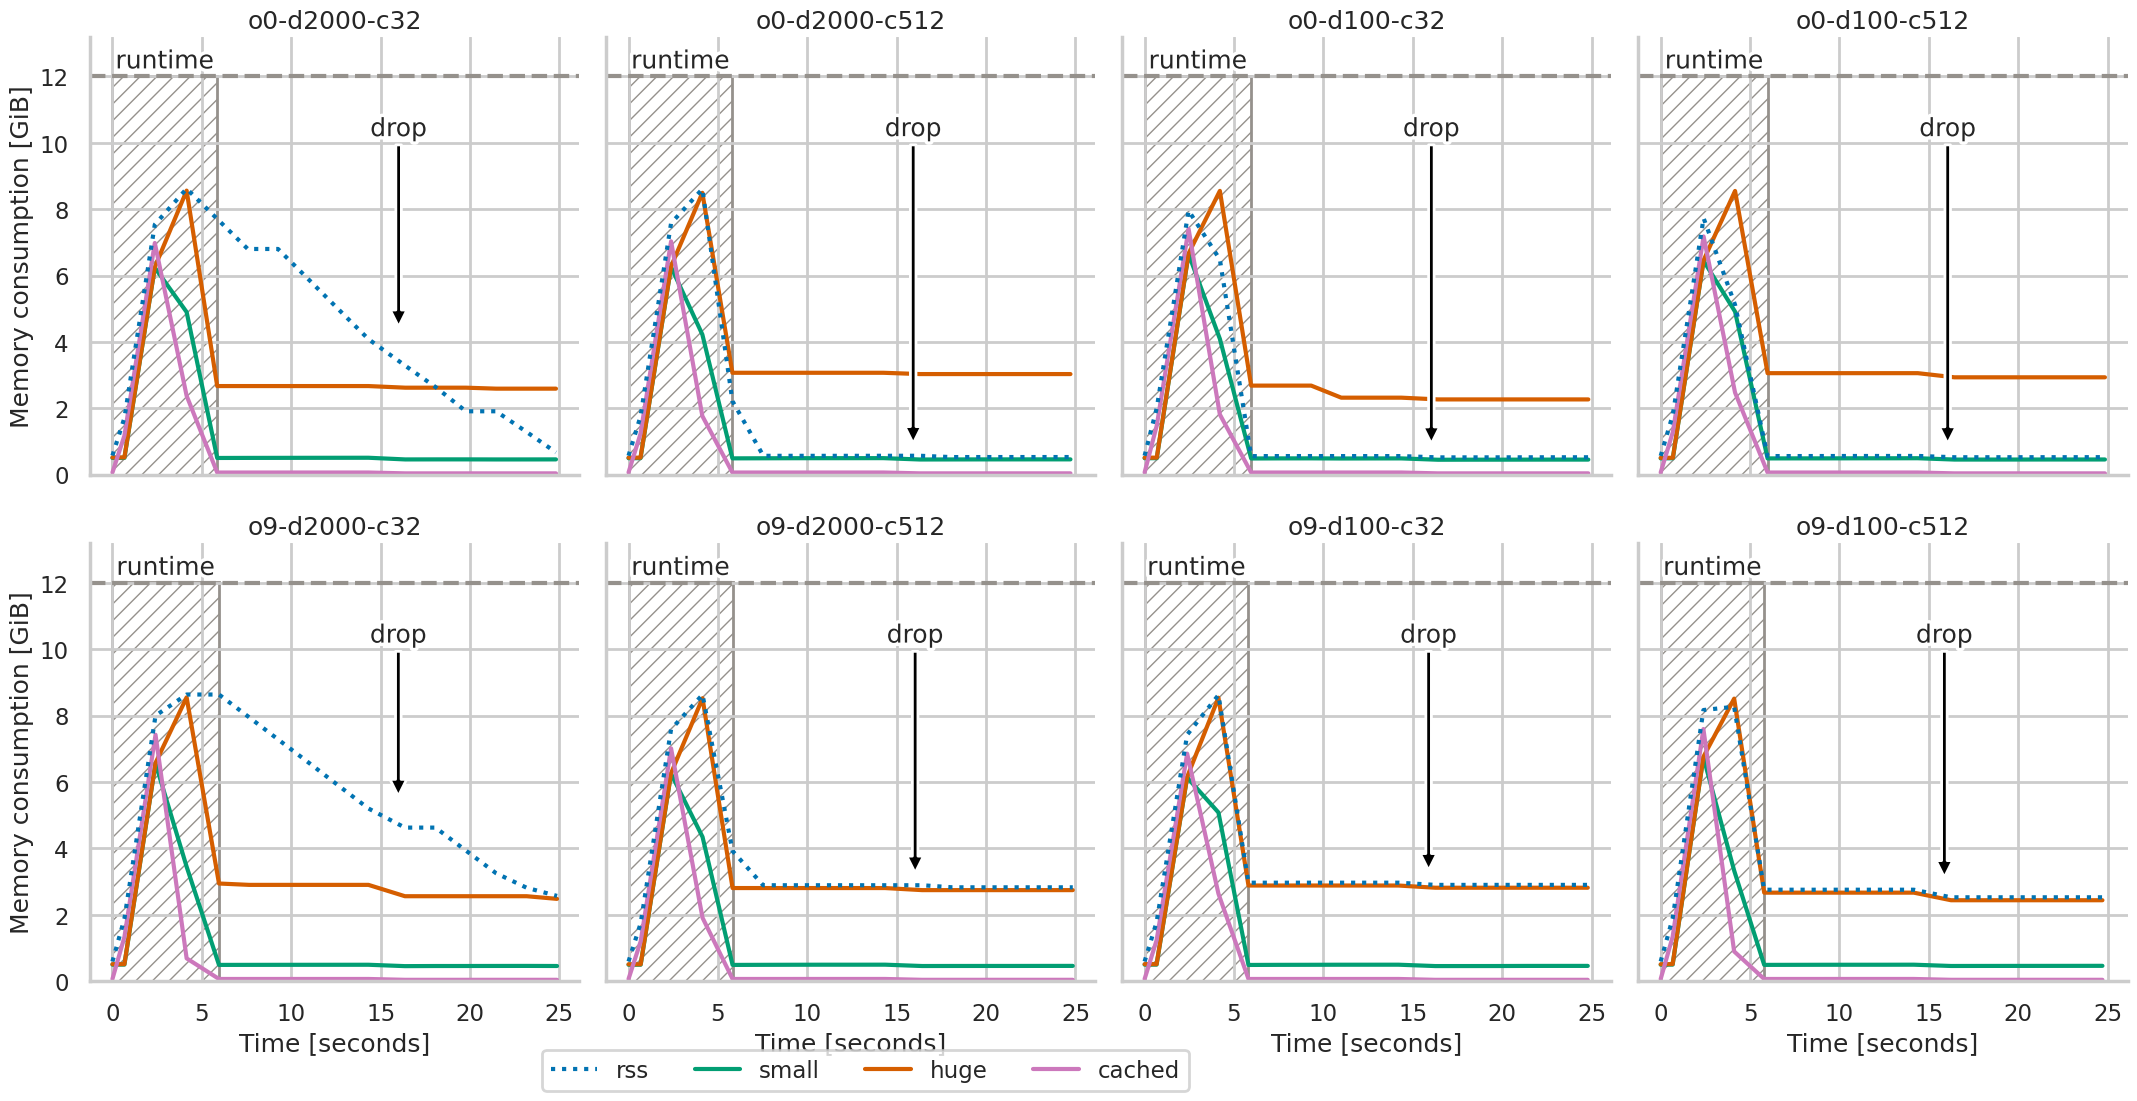

In [3]:
paths = sorted(list(Path("compiling").glob("240826-16*-base-auto-o*-d*-c*")))

modes = { p.stem[24:]: p for p in paths }

max_mem = 12*1024**3
p = visualize(max_mem, modes, col_wrap=4)

In [3]:
from matplotlib import colors
import matplotlib.pyplot as plt

def cscale(rgba: tuple[float, float, float, float], m: float) -> tuple[float, float, float, float]:
    return (rgba[0] * m, rgba[1] * m, rgba[2] * m, rgba[3])

def cmap_extreme(map: colors.Colormap, min=0, max=1) -> colors.Colormap:
    class Wrap(colors.Colormap):
        def __init__(self, cmap: colors.Colormap):
            self.cmap = cmap
        def __getattr__(self, name):
            if name == "cmap": return self.cmap
            return getattr(self.cmap, name)
        def __eq__(self, other):
            self.cmap.__eq__(other)
        def __copy__(self):
            Wrap(self.cmap.__copy__())
        def __call__(self, X, alpha=None, bytes=False):
            if isinstance(X, np.ndarray):
                X = X - (X <= min) + (X >= max)
            if isinstance(X, float) or isinstance(X, int):
                if X <= min:
                    return self.cmap(X - 1.0, alpha, bytes)
                if X >= max:
                    return self.cmap(X + 1.0, alpha, bytes)
            return self.cmap(X, alpha, bytes)

    return Wrap(map.with_extremes(
        under=cscale(map(-1.0), 0.5), over=cscale(map(2.0), 0.5)))

LLFree 16M: 210.64 GiB*m, 1261 s
LLFree 16M: delay 11.83 GiB, clean 8.84 GiB, drop 2.29 GiB, 287.26 GiB*m
LLFree 128M: 210.77 GiB*m, 1262 s
LLFree 128M: delay 12.24 GiB, clean 10.28 GiB, drop 3.23 GiB, 296.60 GiB*m
LLFree 1G: 245.80 GiB*m, 1260 s
LLFree 1G: delay 12.93 GiB, clean 11.10 GiB, drop 6.83 GiB, 348.62 GiB*m


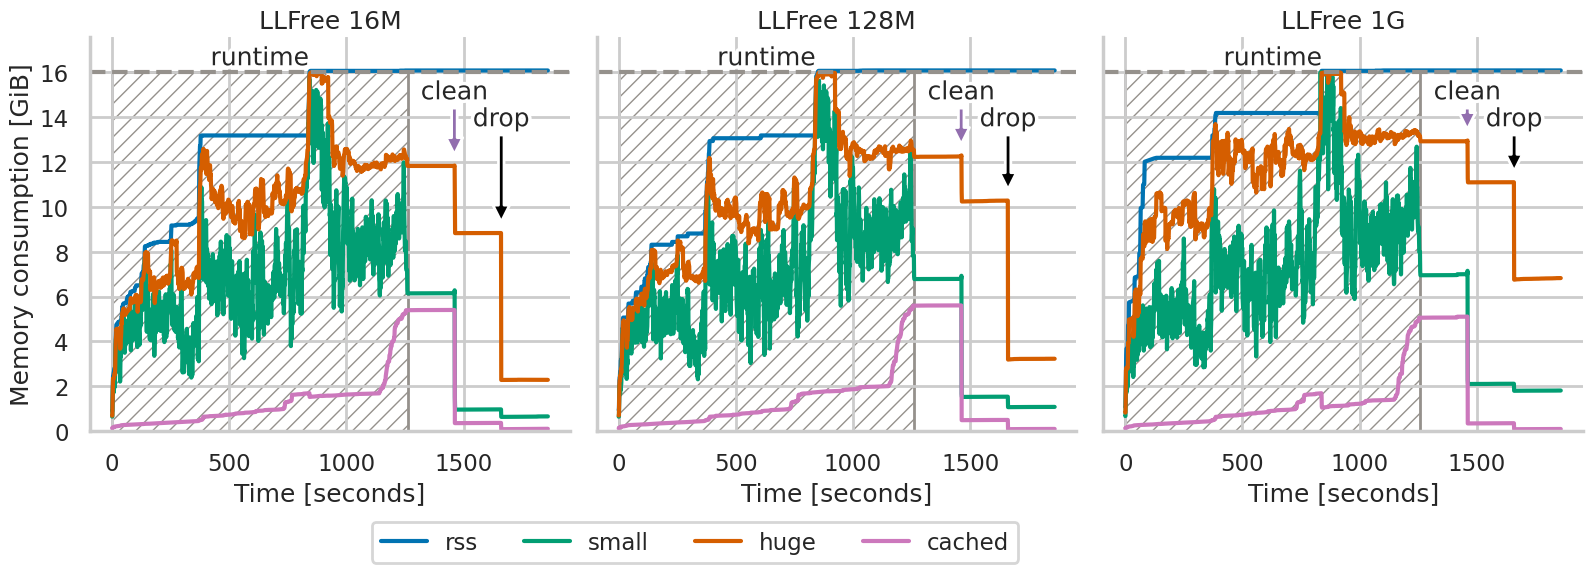

In [11]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "LLFree 16M": Path("compiling/240603-234305-clang-llfree-test"),
    "LLFree 128M": Path("compiling/240603-153327-clang-llfree-test"),
    "LLFree 1G": Path("compiling/240604-175853-clang-llfree-test"),
})

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]


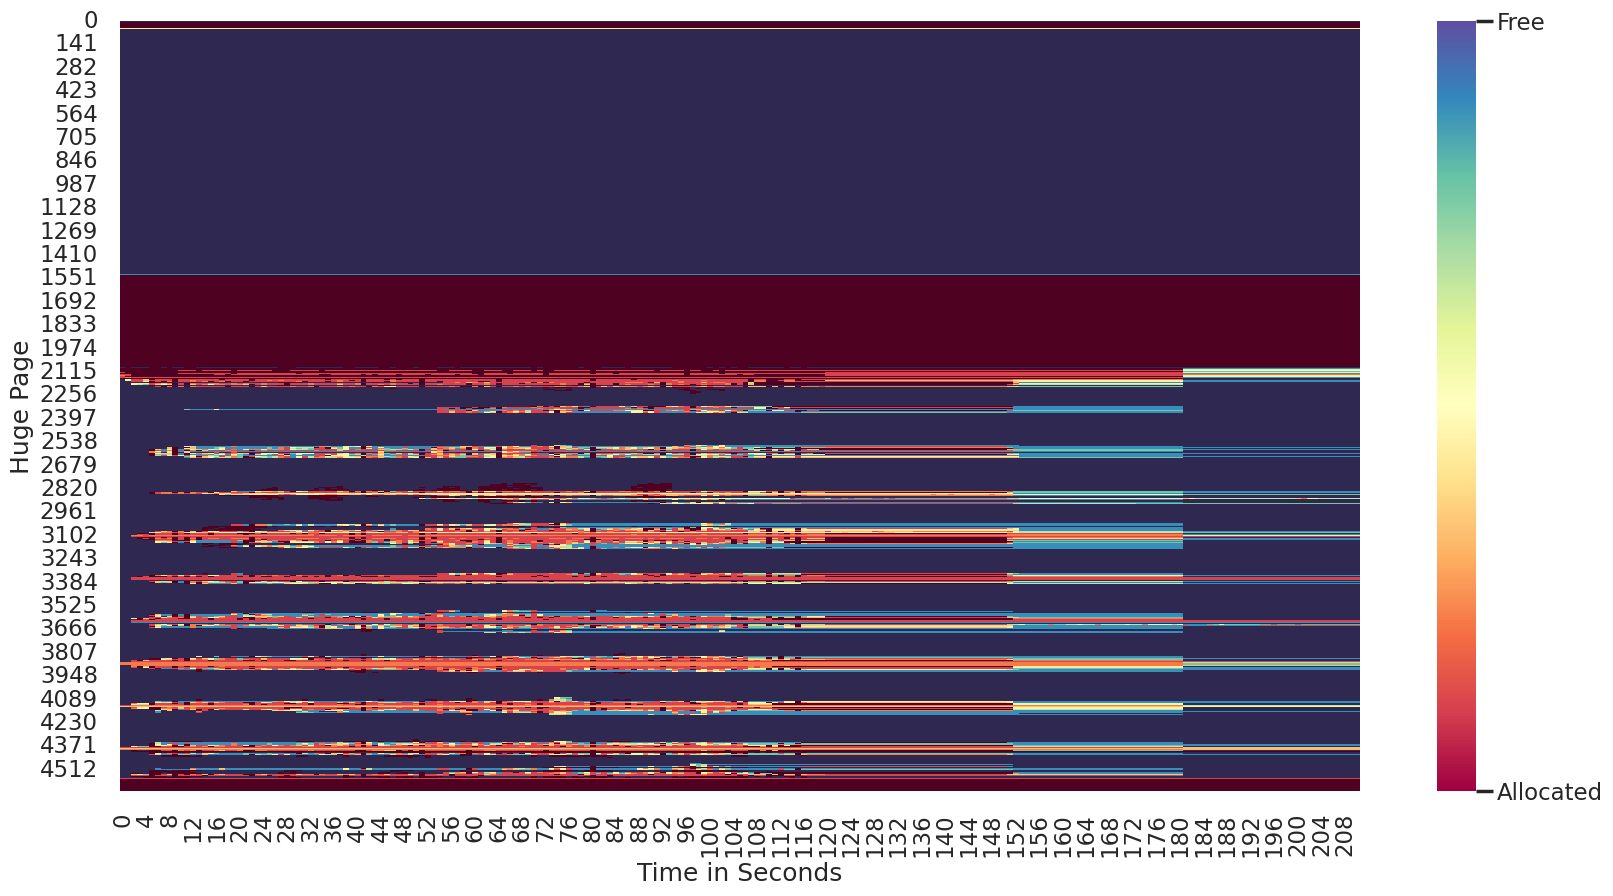

In [9]:
root = Path("compiling/240530-171416-linux-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]


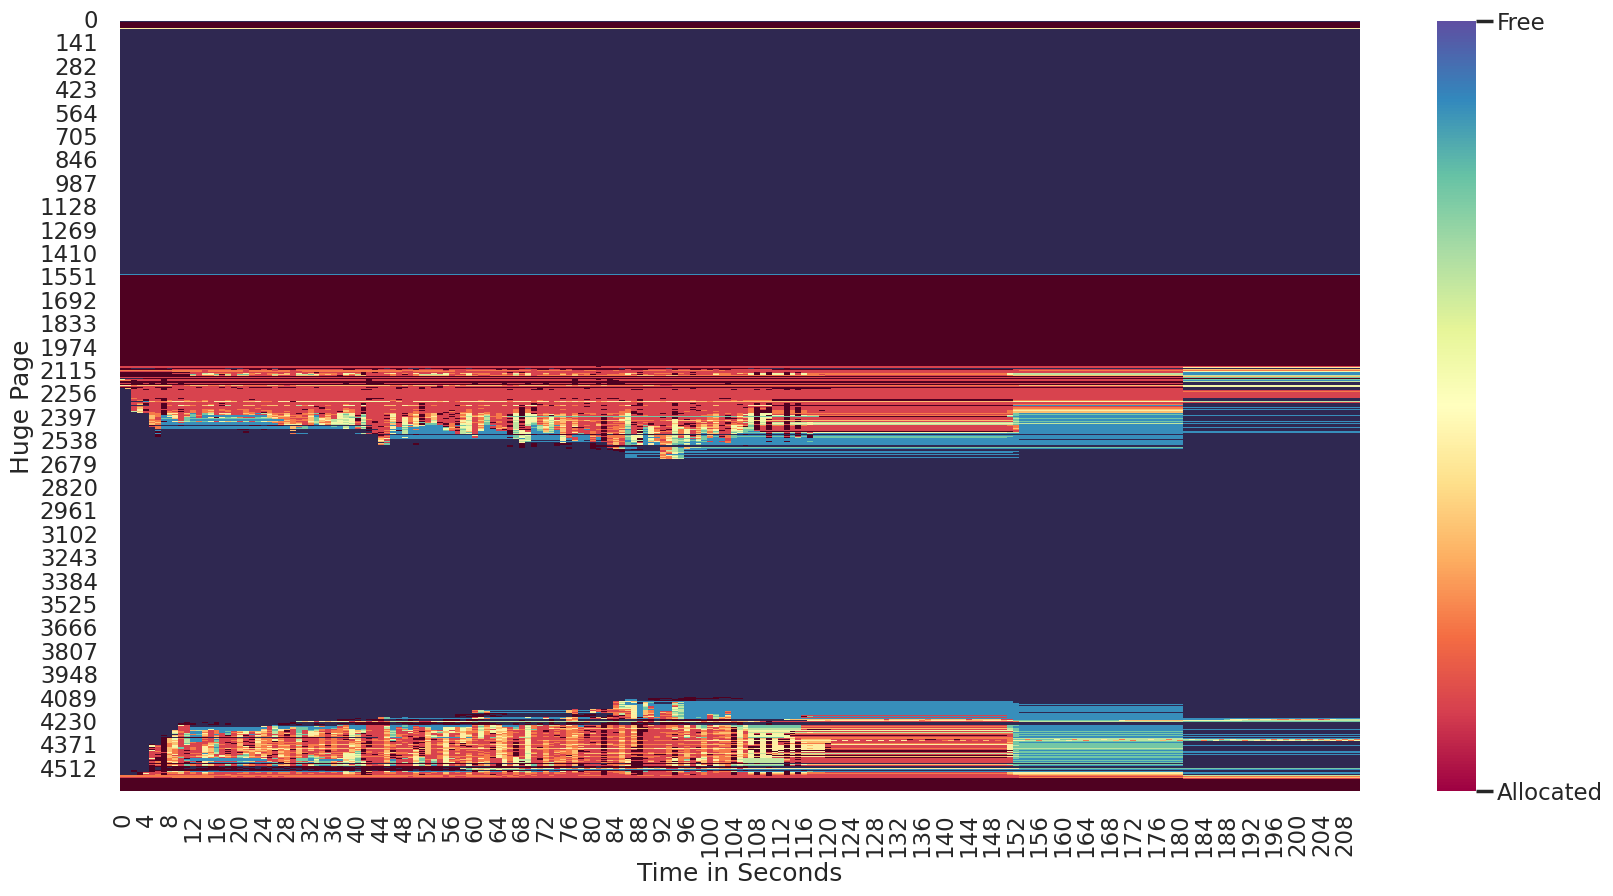

In [11]:
root = Path("compiling/240530-173108-linux-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

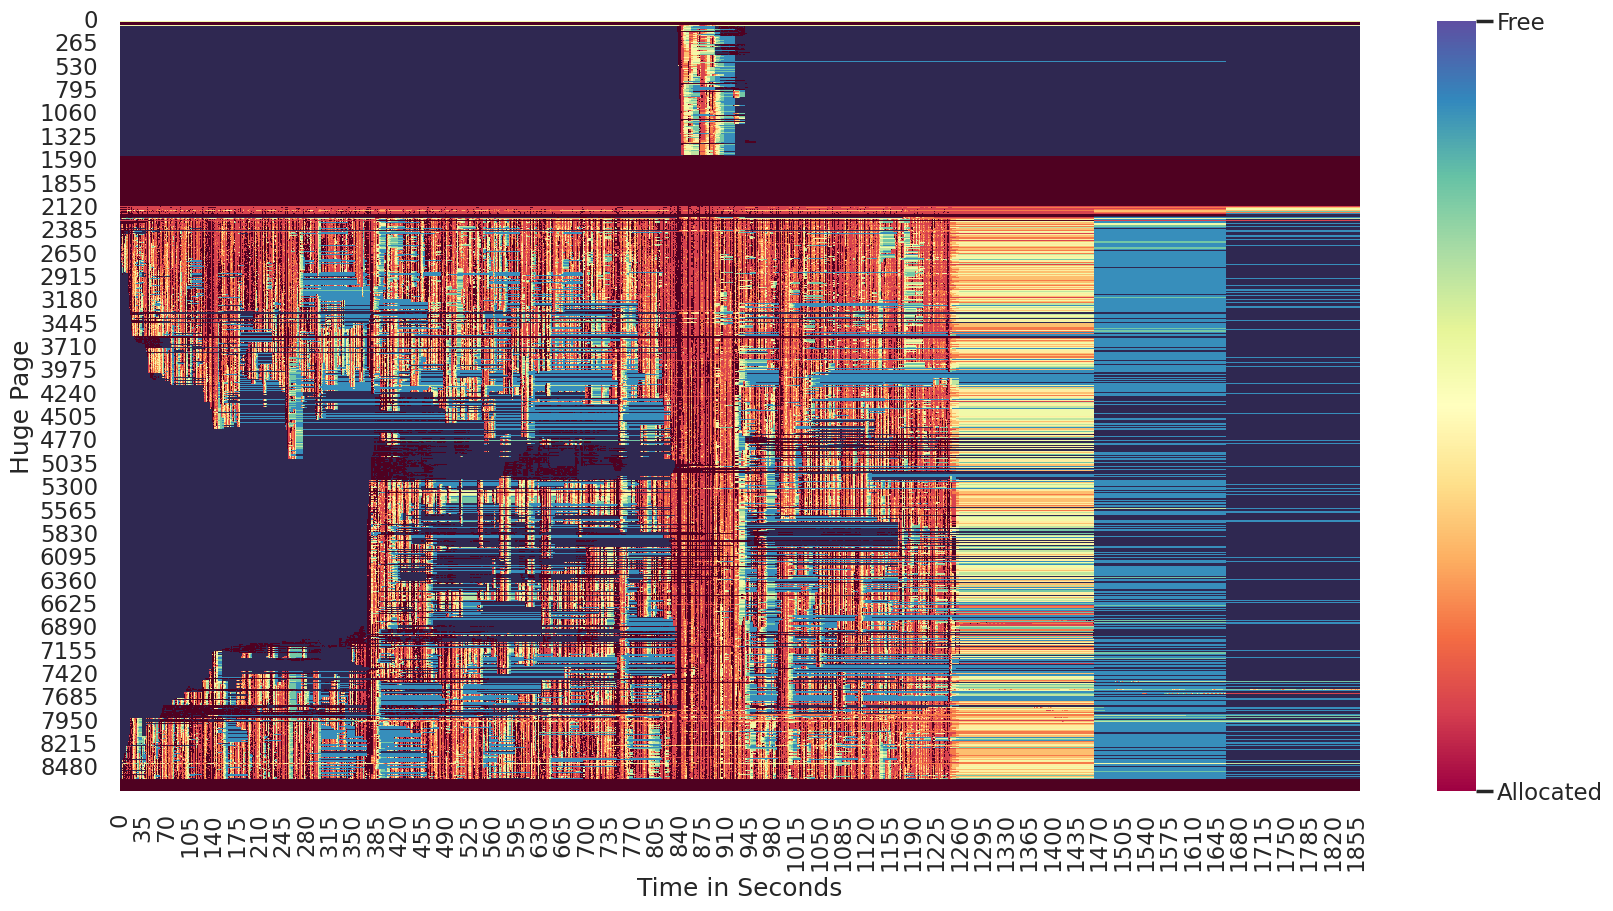

In [4]:
root = Path("compiling/240603-234305-clang-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])